## Lab 01. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [9]:
import string
import os

import torch.nn as nn
import torch
from random import sample
import numpy as np
import torch.nn.functional as F

from torch.autograd import Variable
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [2]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/master/homeworks_basic/Lab2_DL/sonnets.txt

with open('sonnets.txt', 'r', encoding="utf-8") as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [3]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
text = ''.join([sentence.lower() for sentence in text])

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


### Data loading: "Евгений Онегин"


In [4]:
# !wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
    
with open('onegin.txt', 'r', encoding="utf-8") as iofile:
    text = iofile.readlines()
    
text = [x.replace('\t\t', '') for x in text]

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [5]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
out = ''.join([sentence.lower() for sentence in text])

Put all the characters, that you've seen in the text, into variable `tokens`.

In [6]:
tokens = sorted(set(out))

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [7]:
# dict <index>:<char>
# Your great code here
idx_to_token = { index : char for index, char in enumerate(tokens) }

# dict <char>:<index>
# Your great code here
token_to_idx = { char: index for index, char in enumerate(tokens) }

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [51]:
# Your code here

num_tokens = len(tokens)
text_splitted = [' ' + word.strip()  for word in out.split('\n')]
MAX_LENGTH = max(map(len,text_splitted))

class CharRNNCell(nn.Module):
    """
    Implement the scheme above as torch module
    """
    def __init__(self, num_tokens=len(tokens), embedding_size=16, rnn_num_units=64):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.
        
        :param x: batch of character ids, containing vector of int64
        :param h_prev: previous rnn hidden states, containing matrix [batch, rnn_num_units] of float32
        """

        x_emb = self.embedding(x)

        x_and_h = torch.cat([x_emb, h_prev], dim=1)
        h_next = self.rnn_update(x_and_h)   
        h_next = torch.tanh(h_next) 
              
        assert h_next.size() == h_prev.size()
        
        logits = self.rnn_to_logits(h_next)             
        return h_next, F.log_softmax(logits, -1)
    
    def initial_state(self, batch_size):
        return torch.zeros(batch_size, self.num_units, requires_grad=True)

def to_matrix(text, max_len=None, pad=token_to_idx[' '], dtype='int32', batch_first = True):
    """Casts a list of strings into rnn-digestable matrix"""
    max_len = max_len or max(map(len, text))
    text_ix = np.zeros([len(text), max_len], dtype) + pad
    
    for i in range(len(text)):
        line_ix = [token_to_idx[c] for c in text[i]]
        text_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first:
        text_ix = np.transpose(text_ix)

    return text_ix


def rnn_loop(char_rnn, batch_ix):
    """
    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size, max_length = batch_ix.size()
    hid_state = char_rnn.initial_state(batch_size)
    logprobs = []

    for x_t in batch_ix.transpose(0,1):
        hid_state, logp_next = char_rnn(x_t, hid_state)  # <-- here we call your one-step code
        logprobs.append(logp_next)
    
    return torch.stack(logprobs, dim=1)

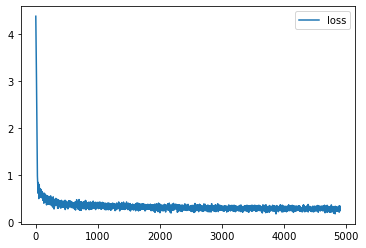

In [52]:
char_rnn = CharRNNCell()
criterion = nn.NLLLoss()
opt = torch.optim.Adam(char_rnn.parameters())
history = []

for i in range(5000):
    batch_ix = to_matrix(sample(text_splitted, 32), max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    logp_seq = rnn_loop(char_rnn, batch_ix)
    
    # compute loss
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = criterion(
        predictions_logp.contiguous().view(-1, num_tokens),
        actual_next_tokens.contiguous().view(-1)
    ) 
    
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    history.append(loss.data.cpu().numpy())
    if i % 100 == 0:
        clear_output(True)
        plt.plot(history, label='loss')
        plt.legend()
        plt.show()

Plot the loss function (axis X: number of epochs, axis Y: loss function).

In [53]:
def generate_sample(char_rnn, seed_phrase=' ', max_length=MAX_LENGTH, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    
    x_sequence = [token_to_idx[token] for token in seed_phrase.lower()]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = char_rnn.initial_state(batch_size=1)
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        hid_state, _ = char_rnn(x_sequence[:, i], hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        hid_state, logp_next = char_rnn(x_sequence[:, -1], hid_state)
        p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [55]:
for _ in range(10):
    print(generate_sample(char_rnn, temperature=1.0))

 ити сернывесни                                                                                                                                                
 и дрепи нослисладвше мила.                                                                                                                                    
 поводост молуже                                                                                                                                               
 какала погро молю,                                                                                                                                            
 и монехь                                                                                                                                                      
 любвы он огобальна елпавая гой жерким коковлаой;                                                                                                              
 ей до умошка чать дет короть:          

### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

In [58]:
class CharLSTM(nn.Module):
    def __init__(self, num_tokens, emb_size=16, n_hidden=300, drop_prob=0.5, n_layers=2):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.lstm = nn.LSTM(emb_size, hidden_size=n_hidden, num_layers=n_layers,
                            dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.hid_to_logits = nn.Linear(n_hidden, num_tokens)

        self.n_layers = n_layers
        self.n_hidden = n_hidden

    def forward(self, x, hidden=None):
        # assert isinstance(x, Variable) and isinstance(x.data, torch.LongTensor)
        ## TODO: Get the outputs and the new hidden state from the lstm
        x = self.emb(x)
        #         print(x.shape)
        if hidden is None:
            r_output, hidden = self.lstm(x)
        else:
            r_output, hidden = self.lstm(x, hidden)

        ## TODO: pass through a dropout layer
        out = self.dropout(r_output)

        # Stack up LSTM outputs using view
        # you may need to use contiguous to reshape the output
        # out = out.contiguous().view(-1, self.n_hidden)

        ## TODO: put x through the fully-connected layer
        next_logits = self.hid_to_logits(out)
        next_logp = F.log_softmax(next_logits, dim=-1)

        # return the final output and the hidden state
        return next_logp, hidden

    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x n_hidden,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data

        if (torch.cuda.is_available()):
            hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda(),
                      weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_(),
                      weight.new(self.n_layers, batch_size, self.n_hidden).zero_())

        return hidden

def to_matrix(data, token_to_id, max_len=None, dtype='int32', batch_first = True):
    """Casts a list of names into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len, data))
    data_ix = np.zeros([len(data), max_len], dtype) + token_to_id[' ']

    for i in range(len(data)):
        line_ix = [token_to_id[c] for c in data[i]]
        data_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first: # convert [batch, time] into [time, batch]
        data_ix = np.transpose(data_ix)

    return data_ix

def generate_sample(model, seed_phrase=' ', max_length=MAX_LENGTH, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    model.eval().cpu()
    x_sequence = [[token_to_idx[token] for token in seed_phrase]]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    
    hidden_s = None
    for i in range(len(seed_phrase) - 1):
        _, hidden_s = model.forward(x_sequence[:, :, i], hidden_s)
    
    for _ in range(max_length - len(seed_phrase)):
        logp_next, hidden_s = model.forward(x_sequence[:, :, -1], hidden_s)
        p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0]
        next_ix = np.random.choice(len(tokens), p=p_next[0])
        next_ix = torch.tensor([[[next_ix]]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=2)
        
    return ''.join([tokens[ix] for ix in x_sequence[0, 0].data.numpy()])

CharLSTM(
  (emb): Embedding(83, 500)
  (lstm): LSTM(500, 300, num_layers=3, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (hid_to_logits): Linear(in_features=300, out_features=83, bias=True)
)

Plot the loss function of the number of epochs. Does the final loss become better?

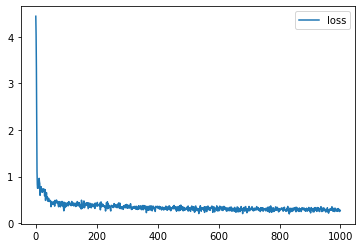

In [64]:
history = []
batch_size = 32
model = CharLSTM(num_tokens, emb_size=500, drop_prob=0.2, n_hidden=300, n_layers=3)
opt = torch.optim.Adam(model.parameters())
model.train()
model.cuda()

for i in range(1000):
    batch_ix = to_matrix(sample(text_splitted, batch_size), token_to_idx, max_len=MAX_LENGTH)
    batch_ix = Variable(torch.LongTensor(batch_ix)).cuda()

    logp_seq, hidden = model(batch_ix)
    #     print(logp_seq.shape)
    
    # compute loss
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = -torch.mean(torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None]))
    
    # train with backprop
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    history.append(loss.data.cpu().numpy())
    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.plot(history, label='loss')
        plt.legend()
        plt.show()

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [66]:
# Text generation with different temperature values here
for temperature in [0.1, 0.2, 0.5, 1.0, 2.0]:
    print ('\nTemperature = ' + str(temperature))
    for _ in range(5):
        
        print(generate_sample(model, temperature=temperature))


Temperature = 0.1
                                                                                                                                                               
                                                                                                                                                               
                                                                                                                                                               
                                                                                                                                                               
                                                                                                                                                               

Temperature = 0.2
                                                                                                                                                               
  

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [98]:
filepath = "CharLSTM_gpu.pth"

# Save model's state_dict
checkpoint = {
    'model': CharLSTM(num_tokens, emb_size=500, drop_prob=0.2, n_hidden=300, n_layers=3),
    'state_dict': model.state_dict(),
}

torch.save(checkpoint, filepath)

In [99]:
# Load model's state_dict
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False

    model.eval()
    return model

new_model = load_checkpoint(filepath)

In [100]:
# Generate text
for _ in range(5):
    print(generate_sample(new_model, temperature=1.0))

 и норин? намавать                                                                                                                                             
 стеруй де товил зествыкой-каен;                                                                                                                               
 перку трлуго уногой вожей                                                                                                                                     
 когзаот моебев; и девой,                                                                                                                                      
 изеньнежной земи, в тохт бюбол);                                                                                                                              


### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)